# Model_AE_Inception_Encoder_only

## Settings
- Normal AE with Inception modules
- No inception modules in the decoder
- "Normal" meaning no latent variable layers
- Simple MSEloss

In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import itertools
import copy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torchviz import make_dot
import gc

# import image based recommendation module
from ibfilter import ImageBasedRecommendation

---
## Data Prep
---

In [3]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:501]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [4]:
# check file count
print(len(os.listdir("../assets/character_images/character_images_grayscale_test/")))

500


In [5]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        character_id = self.target_imgs[idx].split(".")[0]
        # first is input to the model, second is input for reconstruction, third is the character_id for future ref
        return tensor_img, tensor_img, character_id

In [6]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * train_ratio)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    all_data_loader = DataLoader(manga_dataset, batch_size=batch_size)
    return train_loader, val_loader, all_data_loader

---
## AE with Inception modules
---

In [28]:
# Codes to build individual modules

# encoder modules
def single_encoder_module(in_c, out_c, k=1, s=1, p=0):
    module = nn.Sequential(nn.Conv2d(in_c, out_c, kernel_size=k, stride=s, padding=p),
                           nn.BatchNorm2d(out_c),
                           nn.ReLU(inplace=True))
    return module

def single_downsampling_module(in_c, pooling):
    module = nn.Sequential(nn.AvgPool2d(pooling),
                           nn.Conv2d(in_c, in_c*pooling, kernel_size=1),
                           nn.BatchNorm2d(in_c*pooling),
                           nn.ReLU(inplace=True))
    return module

In [29]:
# Inception modules

class EncoderInceptionModule(nn.Module):
    def __init__(self, channels):
        super().__init__()
        bn_ch = channels // 2
        self.bottleneck = single_encoder_module(channels, bn_ch, 1)
        self.conv1 = single_encoder_module(bn_ch, channels, 1)
        self.conv2 = single_encoder_module(bn_ch, channels, 3, p=1)
        self.conv3 = single_encoder_module(bn_ch, channels, 5, p=2)
        self.conv4 = single_encoder_module(bn_ch, channels, 7, p=3)
        self.pool1 = nn.MaxPool2d(3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(5, stride=1, padding=2)

    def forward(self, x):
        bn = self.bottleneck(x)
        # addition instead of concat might be better: (japanese article) https://qiita.com/koshian2/items/e2d05d9151f5ae9deefb
        out = self.conv1(bn) + self.conv2(bn) + self.conv3(bn) + self.conv4(bn) + self.pool1(x) + self.pool2(x)
        return out

In [30]:
# Encoder and decoder modules
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # shallower version
        # self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        # self.e_incep1 = EncoderInceptionModule(32)
        # self.up_ch2 = single_downsampling_module(32, 4)
        # self.e_incep2 = EncoderInceptionModule(128)
        # self.up_ch3 = single_downsampling_module(128, 4)
        # self.e_incep3 = EncoderInceptionModule(512) # [8, 512, 12, 12]

        # deeper version
        self.up_ch1 = nn.Conv2d(1, 32, kernel_size=1)
        self.e_incep1 = EncoderInceptionModule(32)
        self.up_ch2 = single_downsampling_module(32, 2)
        self.e_incep2 = EncoderInceptionModule(64)
        self.up_ch3 = single_downsampling_module(64, 2)
        self.e_incep3 = EncoderInceptionModule(128)
        self.up_ch4 = single_downsampling_module(128, 2)
        self.e_incep4 = EncoderInceptionModule(256)
        self.up_ch5 = single_downsampling_module(256, 2)
        self.e_incep5 = EncoderInceptionModule(512)
        # self.flatten = nn.Flatten(start_dim=1) 

    def forward(self, x):
        # print("x", x.shape)
        out = self.e_incep1(self.up_ch1(x))
        # print("e_incep1", out.shape)
        out = self.e_incep2(self.up_ch2(out))
        # print("e_incep2", out.shape)
        out = self.e_incep3(self.up_ch3(out))
        # print("e_incep3", out.shape)
        out = self.e_incep4(self.up_ch4(out))
        # print("e_incep4", out.shape)
        out = self.e_incep5(self.up_ch5(out))
        # print("e_incep5", out.shape)
        # out = F.avg_pool2d(out, 6)
        # out = self.flatten(out)
        return out


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        # self.down_ch1 = single_upsampling_module_custom(512, 128, k=3, s=2)
        # self.down_ch2 = single_upsampling_module_custom(128, 32, k=3, s=2)
        # self.down_ch3 = single_upsampling_module_custom(32, 1, k=3, s=2, p=1)
        self.conv1 = nn.ConvTranspose2d(512, 256, kernel_size=1, stride=2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2)
        self.relu2 = nn.ReLU(inplace=True)
        self.conv3 = nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.conv4 = nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2, output_padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.conv5 = nn.ConvTranspose2d(32, 1, kernel_size=1, stride=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.sig5 = nn.Sigmoid()

    def forward(self, x):
        # print("decoder input", x.shape)
        out = self.relu1(self.conv1(x))
        # print("relu1", out.shape)
        out = self.relu2(self.conv2(out))
        # print("relu2", out.shape)
        out = self.relu3(self.conv3(out))
        # print("relu3", out.shape)
        out = self.relu4(self.conv4(out))
        # print("relu4", out.shape)
        out = self.relu5(self.conv5(out))
        # print("relu5", out.shape)
        out = self.sig5(out)
        # print("sig5", out.shape)
        return torch.sigmoid(out)

In [31]:
# AE model with inception modules
class AE_Inception(nn.Module):

    def __init__(self, device):
        super().__init__()
        self.device = device
        
        self.encoder = Encoder()
        self.decoder = Decoder()
        # self.initialize_weights()

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="linear")
                if m.out_features == 1000:
                    nn.init.zeros_(m.bias)
                else:
                    nn.init.constant_(m.bias, 0.2)
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_uniform_(m.weight, nonlinearity="conv2d")

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        return out

---
## Test runs
---

In [32]:
# !nvidia-smi

In [33]:
# empty gpu cache
torch.cuda.empty_cache()

In [67]:
# test VAE
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      # transforms.RandomRotation(90),
                                      # transforms.RandomHorizontalFlip(),
                                      # transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=16)

# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = AE_Inception(device=device)
model.train()
model.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(model.parameters())
optimizer = optim.Adam(ae_params, lr=0.005)

# train
losses = []

for epoch in tqdm(range(10)):
    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        out = model(train_img)
        # print(type(z), type(target_img))

        loss = criterion(out, target_img)
        # loss = bce_kld_loss(z, target_img, mu, log_var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, out
        gc.collect()
    avg_loss = running_loss / counter
    losses.append(avg_loss)

cuda


100%|██████████████████████████████████████████████████████████████████████████| 10/10 [03:56<00:00, 23.61s/it]


In [68]:
# !nvidia-smi
# # !kill -9 12547

[0.10467148393392563, 0.0988695314526558, 0.09148020565509796, 0.09031623333692551, 0.09000341266393662, 0.08978782206773758, 0.08968534409999847, 0.08961787700653076, 0.08951237797737122, 0.08921596437692642]


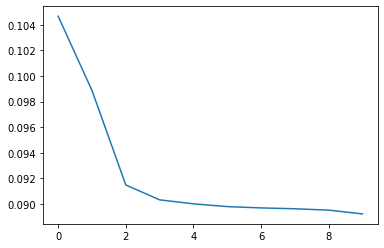

In [69]:
# quick plot of training losses
plt.plot(losses)
print(losses)

In [70]:
model.eval()

# validate
val_losses = []

for epoch in tqdm(range(10)):
    with torch.no_grad():
        running_loss = 0.0
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            out = model(train_img)

            # calculate loss
            loss = criterion(out, target_img)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        val_losses.append(avg_loss)

100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.80s/it]


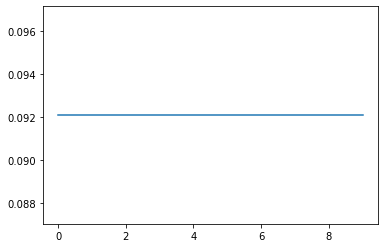

In [71]:
# quick plot of training losses
plt.plot(val_losses)

---
## Train
---

In [14]:
# !nvidia-smi

In [34]:
# version setting
version = "v6"

In [35]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"

# visualize model
x = torch.zeros(8, 1, 200, 200, dtype=torch.float, requires_grad=False)
model = AE_Inception(device=device)
model.train()
model.to(device)
out = model(x.to(device))
make_dot(out, params=dict(list(model.named_parameters()))).render(version+"_inception_ae_torchviz", format="png")

'v6_inception_ae_torchviz.png'

In [36]:
# Putting training and validation into methods
def train_step(model, train_loader, optimizer, device):
    model.train()

    running_loss = 0.0
    for counter, (train_img, target_img, _) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        optimizer.zero_grad()
        out = model(train_img)
        loss = criterion(out, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # clean up
        del train_img, target_img, out
        gc.collect()

    avg_loss = running_loss / counter
    return avg_loss


def val_step(model, val_loader, device):
    model.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img, _) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)
            out = model(train_img)
            loss = criterion(out, target_img)
            running_loss += loss.item()
            
            # clean up
            del train_img, target_img, out, loss
            gc.collect()

        avg_loss = running_loss / counter
        return avg_loss

In [37]:
# empty gpu cache
torch.cuda.empty_cache()

In [38]:
# train and validate to check that the methods work

# redo the settings all again

# set data
# better with batch_size=64 rather than 32 (32 can end up with training curve not going down)
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.CenterCrop(200),
                                      # transforms.RandomRotation(45),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.Normalize(mean=[0], std=[1.0])
                                     ])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.8, batch_size=16)


# initialize again, set to train mode, send models to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = "cpu"
print(device)
model = AE_Inception(device=device)
model.train()
model.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(model.parameters())
optimizer = optim.Adam(ae_params, lr=0.001)

# train
losses = []

# check that it works
EPOCHS = 100
train_losses = []
val_losses = []
min_loss = 1e5

for epoch in tqdm(range(1, EPOCHS+1)):
    train_loss = train_step(model, train_loader, optimizer, device=device)
    train_losses.append(train_loss)
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(model, val_loader, device=device)
    val_losses.append(val_loss)
    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

    # Save the best model
    if val_loss < min_loss:
        best_model = copy.deepcopy(model)
        torch.save(best_model.state_dict(), "../assets/character_images/models_and_embeddings/best_model_"+version+".pt")
        min_loss = val_loss


cuda


  0%|                                                                                  | 0/100 [00:00<?, ?it/s]

Epochs = 1, Training Loss : 0.10123462736606598
Epochs = 1, Validation Loss : 0.103584067097732


  1%|▋                                                                         | 1/100 [00:26<43:01, 26.08s/it]

Epochs = 2, Training Loss : 0.091028873026371
Epochs = 2, Validation Loss : 0.09481505091701235


  2%|█▍                                                                        | 2/100 [00:52<42:56, 26.30s/it]

Epochs = 3, Training Loss : 0.08888290286064147
Epochs = 3, Validation Loss : 0.09446983571563448


  3%|██▏                                                                       | 3/100 [01:18<42:24, 26.23s/it]

Epochs = 4, Training Loss : 0.08851261734962464


  4%|██▉                                                                       | 4/100 [01:44<41:57, 26.23s/it]

Epochs = 4, Validation Loss : 0.09552214933293206
Epochs = 5, Training Loss : 0.08817578345537186
Epochs = 5, Validation Loss : 0.09376189219100135


  5%|███▋                                                                      | 5/100 [02:11<41:40, 26.32s/it]

Epochs = 6, Training Loss : 0.08784119486808777
Epochs = 6, Validation Loss : 0.09339274359600884


  6%|████▍                                                                     | 6/100 [02:37<41:11, 26.29s/it]

Epochs = 7, Training Loss : 0.08759177178144455
Epochs = 7, Validation Loss : 0.09320589793579918


  7%|█████▏                                                                    | 7/100 [03:04<40:54, 26.39s/it]

Epochs = 8, Training Loss : 0.08736673846840859
Epochs = 8, Validation Loss : 0.0931399187871388


  8%|█████▉                                                                    | 8/100 [03:30<40:24, 26.36s/it]

Epochs = 9, Training Loss : 0.08714069694280624
Epochs = 9, Validation Loss : 0.09280462775911603


  9%|██████▋                                                                   | 9/100 [03:57<40:07, 26.45s/it]

Epochs = 10, Training Loss : 0.08684814512729645
Epochs = 10, Validation Loss : 0.09278830885887146


 10%|███████▎                                                                 | 10/100 [04:23<39:32, 26.36s/it]

Epochs = 11, Training Loss : 0.08669616878032685
Epochs = 11, Validation Loss : 0.09269023048026222


 11%|████████                                                                 | 11/100 [04:49<39:14, 26.45s/it]

Epochs = 12, Training Loss : 0.08655650049448013
Epochs = 12, Validation Loss : 0.09240806209189552


 12%|████████▊                                                                | 12/100 [05:16<38:44, 26.41s/it]

Epochs = 13, Training Loss : 0.08645224690437317


 13%|█████████▍                                                               | 13/100 [05:42<38:02, 26.23s/it]

Epochs = 13, Validation Loss : 0.09255489600556237
Epochs = 14, Training Loss : 0.08641344040632248


 14%|██████████▏                                                              | 14/100 [06:08<37:31, 26.18s/it]

Epochs = 14, Validation Loss : 0.09246836283377238
Epochs = 15, Training Loss : 0.0863664373755455
Epochs = 15, Validation Loss : 0.09231845502342496


 15%|██████████▉                                                              | 15/100 [06:34<37:06, 26.19s/it]

Epochs = 16, Training Loss : 0.0864283400774002


 16%|███████████▋                                                             | 16/100 [07:00<36:37, 26.16s/it]

Epochs = 16, Validation Loss : 0.09233531355857849
Epochs = 17, Training Loss : 0.0864146263897419


 17%|████████████▍                                                            | 17/100 [07:26<36:02, 26.05s/it]

Epochs = 17, Validation Loss : 0.09234837868383952
Epochs = 18, Training Loss : 0.08633628964424134
Epochs = 18, Validation Loss : 0.0922102587563651


 18%|█████████████▏                                                           | 18/100 [07:52<35:49, 26.22s/it]

Epochs = 19, Training Loss : 0.08606391221284866


 19%|█████████████▊                                                           | 19/100 [08:18<35:09, 26.04s/it]

Epochs = 19, Validation Loss : 0.09234912480626788
Epochs = 20, Training Loss : 0.0860742250084877
Epochs = 20, Validation Loss : 0.0921618714928627


 20%|██████████████▌                                                          | 20/100 [08:44<34:52, 26.16s/it]

Epochs = 21, Training Loss : 0.0859647411108017


 21%|███████████████▎                                                         | 21/100 [09:10<34:21, 26.10s/it]

Epochs = 21, Validation Loss : 0.09217398187943868
Epochs = 22, Training Loss : 0.08598825454711914
Epochs = 22, Validation Loss : 0.09211535964693342


 22%|████████████████                                                         | 22/100 [09:37<33:58, 26.13s/it]

Epochs = 23, Training Loss : 0.08593231707811355
Epochs = 23, Validation Loss : 0.09199179389647075


 23%|████████████████▊                                                        | 23/100 [10:03<33:38, 26.22s/it]

Epochs = 24, Training Loss : 0.08593292027711869


 24%|█████████████████▌                                                       | 24/100 [10:29<33:00, 26.07s/it]

Epochs = 24, Validation Loss : 0.09210746948208128
Epochs = 25, Training Loss : 0.08582815557718276
Epochs = 25, Validation Loss : 0.09196874392884118


 25%|██████████████████▎                                                      | 25/100 [10:55<32:47, 26.24s/it]

Epochs = 26, Training Loss : 0.08594590157270432


 26%|██████████████████▉                                                      | 26/100 [11:21<32:11, 26.09s/it]

Epochs = 26, Validation Loss : 0.0927862673997879
Epochs = 27, Training Loss : 0.08595727890729904
Epochs = 27, Validation Loss : 0.09187809058598109


 27%|███████████████████▋                                                     | 27/100 [11:48<31:58, 26.28s/it]

Epochs = 28, Training Loss : 0.08574562951922417


 28%|████████████████████▍                                                    | 28/100 [12:14<31:20, 26.12s/it]

Epochs = 28, Validation Loss : 0.09193076406206403
Epochs = 29, Training Loss : 0.08571605086326599


 29%|█████████████████████▏                                                   | 29/100 [12:39<30:44, 25.98s/it]

Epochs = 29, Validation Loss : 0.09192690572568349
Epochs = 30, Training Loss : 0.08569255381822587
Epochs = 30, Validation Loss : 0.09176596466984067


 30%|█████████████████████▉                                                   | 30/100 [13:06<30:35, 26.22s/it]

Epochs = 31, Training Loss : 0.0855736231803894
Epochs = 31, Validation Loss : 0.09175791910716466


 31%|██████████████████████▋                                                  | 31/100 [13:32<30:08, 26.20s/it]

Epochs = 32, Training Loss : 0.08552139610052109
Epochs = 32, Validation Loss : 0.09166722531829562


 32%|███████████████████████▎                                                 | 32/100 [13:59<29:48, 26.30s/it]

Epochs = 33, Training Loss : 0.08547034651041031


 33%|████████████████████████                                                 | 33/100 [14:25<29:11, 26.15s/it]

Epochs = 33, Validation Loss : 0.09177087140934807
Epochs = 34, Training Loss : 0.08559698775410653


 34%|████████████████████████▊                                                | 34/100 [14:51<28:42, 26.10s/it]

Epochs = 34, Validation Loss : 0.09172630948679787
Epochs = 35, Training Loss : 0.0855547198653221


 35%|█████████████████████████▌                                               | 35/100 [15:16<28:10, 26.00s/it]

Epochs = 35, Validation Loss : 0.09171163716486522
Epochs = 36, Training Loss : 0.08556501269340515
Epochs = 36, Validation Loss : 0.09165704569646291


 36%|██████████████████████████▎                                              | 36/100 [15:42<27:46, 26.04s/it]

Epochs = 37, Training Loss : 0.0854199680685997


 37%|███████████████████████████                                              | 37/100 [16:09<27:24, 26.10s/it]

Epochs = 37, Validation Loss : 0.09169530655656542
Epochs = 38, Training Loss : 0.08551910936832428
Epochs = 38, Validation Loss : 0.09161528838532311


 38%|███████████████████████████▋                                             | 38/100 [16:35<27:01, 26.15s/it]

Epochs = 39, Training Loss : 0.08539903670549392


 39%|████████████████████████████▍                                            | 39/100 [17:01<26:35, 26.16s/it]

Epochs = 39, Validation Loss : 0.09165196759360177
Epochs = 40, Training Loss : 0.08535304576158524


 40%|█████████████████████████████▏                                           | 40/100 [17:27<26:03, 26.06s/it]

Epochs = 40, Validation Loss : 0.09166290611028671
Epochs = 41, Training Loss : 0.08528220236301422
Epochs = 41, Validation Loss : 0.09150167448180062


 41%|█████████████████████████████▉                                           | 41/100 [17:53<25:41, 26.12s/it]

Epochs = 42, Training Loss : 0.08543942287564278


 42%|██████████████████████████████▋                                          | 42/100 [18:19<25:01, 25.88s/it]

Epochs = 42, Validation Loss : 0.09181858386312212
Epochs = 43, Training Loss : 0.08547899708151817


 43%|███████████████████████████████▍                                         | 43/100 [18:44<24:36, 25.90s/it]

Epochs = 43, Validation Loss : 0.09168366555656705
Epochs = 44, Training Loss : 0.08523835927248001
Epochs = 44, Validation Loss : 0.09147078543901443


 44%|████████████████████████████████                                         | 44/100 [19:10<24:09, 25.88s/it]

Epochs = 45, Training Loss : 0.08516965180635452
Epochs = 45, Validation Loss : 0.09140577699456896


 45%|████████████████████████████████▊                                        | 45/100 [19:36<23:40, 25.84s/it]

Epochs = 46, Training Loss : 0.08514885365962982


 46%|█████████████████████████████████▌                                       | 46/100 [20:02<23:20, 25.94s/it]

Epochs = 46, Validation Loss : 0.0914335697889328
Epochs = 47, Training Loss : 0.08512841999530792
Epochs = 47, Validation Loss : 0.09137971273490361


 47%|██████████████████████████████████▎                                      | 47/100 [20:28<22:50, 25.86s/it]

Epochs = 48, Training Loss : 0.08513592958450317


 48%|███████████████████████████████████                                      | 48/100 [20:54<22:24, 25.85s/it]

Epochs = 48, Validation Loss : 0.09138076539550509
Epochs = 49, Training Loss : 0.08522979974746704


 49%|███████████████████████████████████▊                                     | 49/100 [21:19<21:51, 25.71s/it]

Epochs = 49, Validation Loss : 0.0913865470460483
Epochs = 50, Training Loss : 0.0851022708415985


 50%|████████████████████████████████████▌                                    | 50/100 [21:45<21:28, 25.78s/it]

Epochs = 50, Validation Loss : 0.09139146655797958
Epochs = 51, Training Loss : 0.08526379689574241
Epochs = 51, Validation Loss : 0.0913589916058949


 51%|█████████████████████████████████████▏                                   | 51/100 [22:11<21:01, 25.75s/it]

Epochs = 52, Training Loss : 0.08513389900326729


 52%|█████████████████████████████████████▉                                   | 52/100 [22:36<20:30, 25.65s/it]

Epochs = 52, Validation Loss : 0.09141483477183751
Epochs = 53, Training Loss : 0.08505632340908051
Epochs = 53, Validation Loss : 0.0913536889212472


 53%|██████████████████████████████████████▋                                  | 53/100 [23:03<20:17, 25.91s/it]

Epochs = 54, Training Loss : 0.08525971129536629


 54%|███████████████████████████████████████▍                                 | 54/100 [23:28<19:43, 25.72s/it]

Epochs = 54, Validation Loss : 0.0913714234318052
Epochs = 55, Training Loss : 0.08510645896196366
Epochs = 55, Validation Loss : 0.09133766697985786


 55%|████████████████████████████████████████▏                                | 55/100 [23:54<19:21, 25.81s/it]

Epochs = 56, Training Loss : 0.08508938804268837


 56%|████████████████████████████████████████▉                                | 56/100 [24:19<18:49, 25.68s/it]

Epochs = 56, Validation Loss : 0.09139313335929598
Epochs = 57, Training Loss : 0.08505350440740585
Epochs = 57, Validation Loss : 0.09133126905986241


 57%|█████████████████████████████████████████▌                               | 57/100 [24:46<18:35, 25.94s/it]

Epochs = 58, Training Loss : 0.08503508657217025


 58%|██████████████████████████████████████████▎                              | 58/100 [25:12<18:05, 25.84s/it]

Epochs = 58, Validation Loss : 0.09149853672300066
Epochs = 59, Training Loss : 0.08502747103571892


 59%|███████████████████████████████████████████                              | 59/100 [25:37<17:37, 25.79s/it]

Epochs = 59, Validation Loss : 0.09137189707585744
Epochs = 60, Training Loss : 0.08506780326366424


 60%|███████████████████████████████████████████▊                             | 60/100 [26:03<17:17, 25.93s/it]

Epochs = 60, Validation Loss : 0.09134138375520706
Epochs = 61, Training Loss : 0.08506359905004501


 61%|████████████████████████████████████████████▌                            | 61/100 [26:29<16:50, 25.90s/it]

Epochs = 61, Validation Loss : 0.09155325698001045
Epochs = 62, Training Loss : 0.08500493109226227


 62%|█████████████████████████████████████████████▎                           | 62/100 [26:56<16:30, 26.06s/it]

Epochs = 62, Validation Loss : 0.0913701206445694
Epochs = 63, Training Loss : 0.08492893874645233


 63%|█████████████████████████████████████████████▉                           | 63/100 [27:21<16:01, 25.98s/it]

Epochs = 63, Validation Loss : 0.09153475399528231
Epochs = 64, Training Loss : 0.08507743522524834
Epochs = 64, Validation Loss : 0.09124866766589028


 64%|██████████████████████████████████████████████▋                          | 64/100 [27:48<15:44, 26.22s/it]

Epochs = 65, Training Loss : 0.08491547912359237


 65%|███████████████████████████████████████████████▍                         | 65/100 [28:14<15:14, 26.13s/it]

Epochs = 65, Validation Loss : 0.09133850357362203
Epochs = 66, Training Loss : 0.08499007463455201


 66%|████████████████████████████████████████████████▏                        | 66/100 [28:40<14:46, 26.06s/it]

Epochs = 66, Validation Loss : 0.09157848571028028
Epochs = 67, Training Loss : 0.08495304316282272
Epochs = 67, Validation Loss : 0.09121592449290412


 67%|████████████████████████████████████████████████▉                        | 67/100 [29:07<14:26, 26.26s/it]

Epochs = 68, Training Loss : 0.08487927988171577


 68%|█████████████████████████████████████████████████▋                       | 68/100 [29:33<13:56, 26.13s/it]

Epochs = 68, Validation Loss : 0.09126193608556475
Epochs = 69, Training Loss : 0.08486524492502212
Epochs = 69, Validation Loss : 0.09117245993443898


 69%|██████████████████████████████████████████████████▎                      | 69/100 [29:59<13:35, 26.31s/it]

Epochs = 70, Training Loss : 0.08484050422906876


 70%|███████████████████████████████████████████████████                      | 70/100 [30:25<13:05, 26.17s/it]

Epochs = 70, Validation Loss : 0.09120006965739387
Epochs = 71, Training Loss : 0.08483060032129287


 71%|███████████████████████████████████████████████████▊                     | 71/100 [30:51<12:37, 26.12s/it]

Epochs = 71, Validation Loss : 0.09123480107103075
Epochs = 72, Training Loss : 0.08483839631080628


 72%|████████████████████████████████████████████████████▌                    | 72/100 [31:17<12:09, 26.04s/it]

Epochs = 72, Validation Loss : 0.09119445617709841
Epochs = 73, Training Loss : 0.08487114623188972


 73%|█████████████████████████████████████████████████████▎                   | 73/100 [31:43<11:40, 25.96s/it]

Epochs = 73, Validation Loss : 0.09125987866095134
Epochs = 74, Training Loss : 0.08483674600720406
Epochs = 74, Validation Loss : 0.09117231518030167


 74%|██████████████████████████████████████████████████████                   | 74/100 [32:10<11:22, 26.24s/it]

Epochs = 75, Training Loss : 0.08480733662843704
Epochs = 75, Validation Loss : 0.09115072659083776


 75%|██████████████████████████████████████████████████████▊                  | 75/100 [32:36<10:55, 26.22s/it]

Epochs = 76, Training Loss : 0.08478554755449295
Epochs = 76, Validation Loss : 0.09114155705486025


 76%|███████████████████████████████████████████████████████▍                 | 76/100 [33:02<10:31, 26.30s/it]

Epochs = 77, Training Loss : 0.08480045706033706


 77%|████████████████████████████████████████████████████████▏                | 77/100 [33:28<10:01, 26.13s/it]

Epochs = 77, Validation Loss : 0.09118387741701943
Epochs = 78, Training Loss : 0.08481025964021682


 78%|████████████████████████████████████████████████████████▉                | 78/100 [33:54<09:35, 26.18s/it]

Epochs = 78, Validation Loss : 0.0911710996712957
Epochs = 79, Training Loss : 0.084801175147295


 79%|█████████████████████████████████████████████████████████▋               | 79/100 [34:20<09:06, 26.04s/it]

Epochs = 79, Validation Loss : 0.09114211691277367
Epochs = 80, Training Loss : 0.08475762248039245
Epochs = 80, Validation Loss : 0.09111002832651138


 80%|██████████████████████████████████████████████████████████▍              | 80/100 [34:47<08:46, 26.34s/it]

Epochs = 81, Training Loss : 0.08478665918111801
Epochs = 81, Validation Loss : 0.09108970633574895


 81%|███████████████████████████████████████████████████████████▏             | 81/100 [35:13<08:19, 26.27s/it]

Epochs = 82, Training Loss : 0.0847493690252304


 82%|███████████████████████████████████████████████████████████▊             | 82/100 [35:39<07:49, 26.10s/it]

Epochs = 82, Validation Loss : 0.09122033842972346
Epochs = 83, Training Loss : 0.08470880389213561


 83%|████████████████████████████████████████████████████████████▌            | 83/100 [36:05<07:24, 26.13s/it]

Epochs = 83, Validation Loss : 0.09118353788341794
Epochs = 84, Training Loss : 0.08475988984107971


 84%|█████████████████████████████████████████████████████████████▎           | 84/100 [36:31<06:56, 26.02s/it]

Epochs = 84, Validation Loss : 0.09123433487755912
Epochs = 85, Training Loss : 0.0848115798830986


 85%|██████████████████████████████████████████████████████████████           | 85/100 [36:57<06:30, 26.05s/it]

Epochs = 85, Validation Loss : 0.09120442398956843
Epochs = 86, Training Loss : 0.08476413518190384


 86%|██████████████████████████████████████████████████████████████▊          | 86/100 [37:23<06:03, 25.99s/it]

Epochs = 86, Validation Loss : 0.09110590815544128
Epochs = 87, Training Loss : 0.0846924364566803
Epochs = 87, Validation Loss : 0.09108727957521166


 87%|███████████████████████████████████████████████████████████████▌         | 87/100 [37:49<05:40, 26.16s/it]

Epochs = 88, Training Loss : 0.08470447778701783


 88%|████████████████████████████████████████████████████████████████▏        | 88/100 [38:15<05:12, 26.03s/it]

Epochs = 88, Validation Loss : 0.0911925977894238
Epochs = 89, Training Loss : 0.08472007870674134


 89%|████████████████████████████████████████████████████████████████▉        | 89/100 [38:41<04:45, 25.97s/it]

Epochs = 89, Validation Loss : 0.09157543629407883
Epochs = 90, Training Loss : 0.08472172021865845


 90%|█████████████████████████████████████████████████████████████████▋       | 90/100 [39:07<04:20, 26.03s/it]

Epochs = 90, Validation Loss : 0.0912960416504315
Epochs = 91, Training Loss : 0.08483006536960602


 91%|██████████████████████████████████████████████████████████████████▍      | 91/100 [39:33<03:53, 25.97s/it]

Epochs = 91, Validation Loss : 0.09138584243399757
Epochs = 92, Training Loss : 0.08468028694391251
Epochs = 92, Validation Loss : 0.09104631628308978


 92%|███████████████████████████████████████████████████████████████████▏     | 92/100 [40:00<03:29, 26.17s/it]

Epochs = 93, Training Loss : 0.08470150947570801


 93%|███████████████████████████████████████████████████████████████████▉     | 93/100 [40:26<03:02, 26.08s/it]

Epochs = 93, Validation Loss : 0.09138539433479309
Epochs = 94, Training Loss : 0.08475809782743454


 94%|████████████████████████████████████████████████████████████████████▌    | 94/100 [40:52<02:36, 26.09s/it]

Epochs = 94, Validation Loss : 0.09127957480294364
Epochs = 95, Training Loss : 0.08473683923482894


 95%|█████████████████████████████████████████████████████████████████████▎   | 95/100 [41:17<02:09, 25.88s/it]

Epochs = 95, Validation Loss : 0.09113009061132159
Epochs = 96, Training Loss : 0.08466842651367187


 96%|██████████████████████████████████████████████████████████████████████   | 96/100 [41:42<01:42, 25.72s/it]

Epochs = 96, Validation Loss : 0.09113433957099915
Epochs = 97, Training Loss : 0.08461497098207474


 97%|██████████████████████████████████████████████████████████████████████▊  | 97/100 [42:08<01:17, 25.71s/it]

Epochs = 97, Validation Loss : 0.09109350506748472
Epochs = 98, Training Loss : 0.08463368803262711


 98%|███████████████████████████████████████████████████████████████████████▌ | 98/100 [42:33<00:51, 25.59s/it]

Epochs = 98, Validation Loss : 0.09104706559862409
Epochs = 99, Training Loss : 0.08460684925317764


 99%|████████████████████████████████████████████████████████████████████████▎| 99/100 [42:59<00:25, 25.61s/it]

Epochs = 99, Validation Loss : 0.09114549841199603
Epochs = 100, Training Loss : 0.08467675656080247


100%|████████████████████████████████████████████████████████████████████████| 100/100 [43:24<00:00, 26.05s/it]

Epochs = 100, Validation Loss : 0.0910794734954834


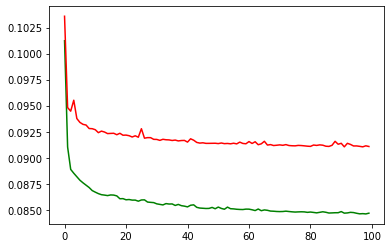

In [39]:
# plot training & validation losses
# print(train_losses[0:10])
plt.plot(train_losses,"g", val_losses, "r")
# plt.ylim(0.0, 1000000)
plt.show()

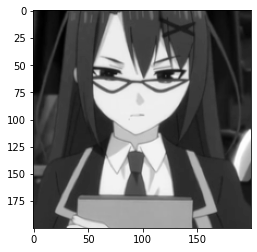

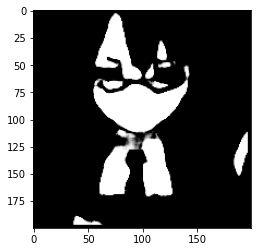

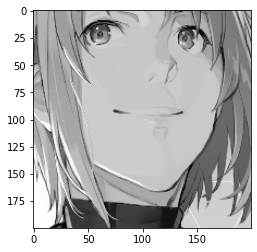

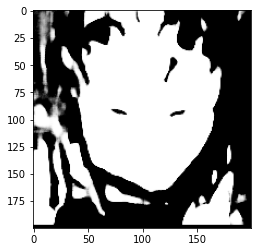

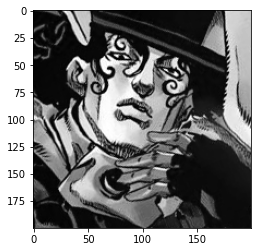

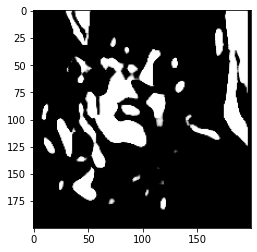

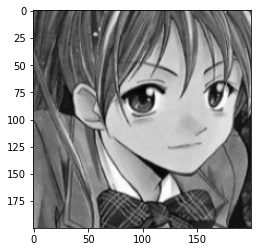

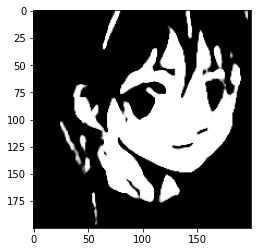

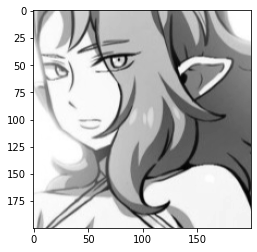

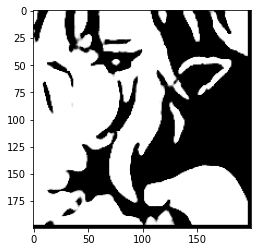

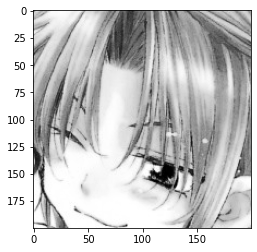

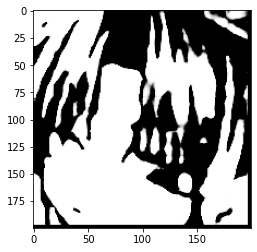

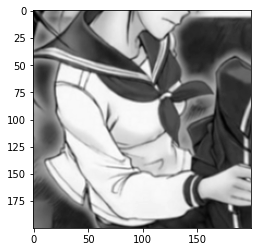

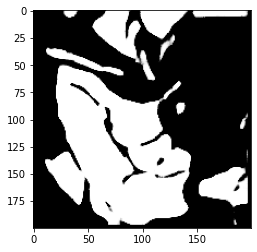

In [40]:
# show what the model learned -> look how validation images are now represented by the decoder
# if the model learned the images well, they should look similar to each other

# Note: 
# when training loss doesn't go down (10 epochs, ~0.4 loss at minimum) -> dec_output is all BLACK and can't see anything
# when training loss goes down (50 epochs, ~0.04) -> dec_output is blurry but somewhat similar to the input

model.eval()
with torch.no_grad():
    for train_img, target_img, _ in val_loader:
        
        train_img = train_img.to(device)
        target_img = target_img.to(device)
        out = model(train_img)
        
        # show only the first image of each batch (output original and decoder output images for comparison)
        for t_img, out_img in zip(train_img[0], out[0]):
            plt.imshow(t_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()
            plt.imshow(out_img.detach().cpu().numpy().squeeze(), cmap="gray")
            plt.show()

---
## Create embedding
---

In [41]:
# create embedding

model.eval()
embedding = torch.zeros((1, 512, 12, 12))
character_ids = []
with torch.no_grad():
    for train_img, target_img, character_id in tqdm(all_data_loader):
        train_img = train_img.to(device)
        out = model.encoder(train_img).cpu()
        embedding = torch.cat((embedding, out), 0)
        character_ids.append(character_id)

100%|██████████████████████████████████████████████████████████████████████████| 32/32 [00:07<00:00,  4.14it/s]


In [42]:
# Convert to numpy and save
character_ids = list(itertools.chain.from_iterable(character_ids))
np_character_ids = np.array(character_ids)
embedding = embedding[1:, :]
print("len of character_ids: ", len(character_ids))
print("shape of embedding: ", embedding.shape)
np_embedding = embedding.cpu().detach().numpy()
num_images = np_embedding.shape[0]

# Save the embeddings
flattened_embedding = np_embedding.reshape((num_images, -1))
print("shape of flattened embedding: ", flattened_embedding.shape)
np.save("../assets/character_images/models_and_embeddings/image_embedding_"+version+".npy", flattened_embedding)
np.save("../assets/character_images/models_and_embeddings/image_embedding_character_ids_"+version+".npy", np_character_ids)

len of character_ids:  500
shape of embedding:  torch.Size([500, 512, 12, 12])
shape of flattened embedding:  (500, 73728)


---
## Similarity calculations (Character-based, Title-based)
---

In [2]:
# initialize
ibr_search = ImageBasedRecommendation("/mnt/disks/sdb/home/dy0904k/assets/character_images/character_images_grayscale/", "v6")

model version:  v6


Queried character:  ['Jirou Azuma']  who appears in:  ['BLACK TORCH']


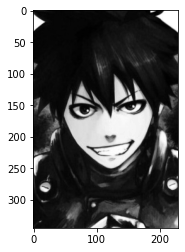

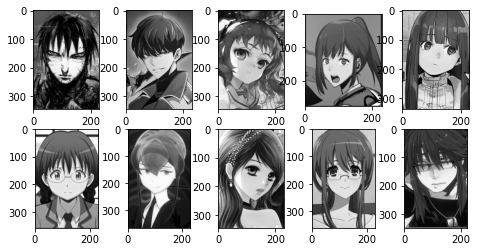

Similar characters (in the order of appearance)
Character:  ['Killy']  who appears in :  ['BLAME!' 'NOiSE' 'Blame! Gakuen And So On' 'BLAME!²'
 'Blame!: Denki Ryoushi Kiken Kaisou Dasshutsu Sakusen' 'BLAME']
Character:  ['Jin-Hyeok Kang']  who appears in :  ['Na Honja Mallep Newbie']
Character:  ['Mito Juujou']  who appears in :  ['Owari no Seraph'
 'Owari no Seraph: Ichinose Guren, 16-sai no Catastrophe'
 'Owari no Seraph: Ichinose Guren, 19-sai no Sekai Resurrection']
Character:  ['Jin-Ah Sung']  who appears in :  ['Na Honjaman Level Up']
Character:  ['Fern']  who appears in :  ['Sousou no Frieren']
Character:  ['Manami Okuda']  who appears in :  ['Ansatsu Kyoushitsu']
Character:  ['Jade']  who appears in :  ['Houseki no Kuni']
Character:  ['Teru Kurebayashi']  who appears in :  ['Dengeki Daisy']
Character:  ['Reiko Mikami']  who appears in :  ['Another' 'Another 0']
Character:  ['Ginger']  who appears in :  ['GANGSTA.']
[105398  69883  74489  30149  73661 118586  35255  54903  54098

In [3]:
res = ibr_search.recommend_titles_from_similar_characters(query_character_id=137304, top_n=10)
print(res)

Querying title:  ['Berserk']


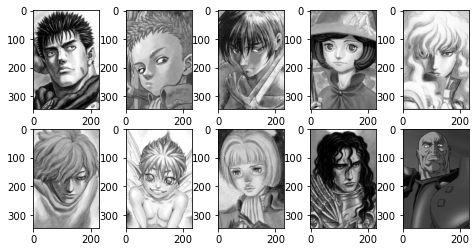

Similar title:  ['Shingeki no Kyojin']


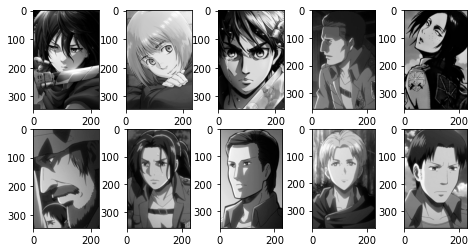

Similar title:  ['Na Honjaman Level Up']


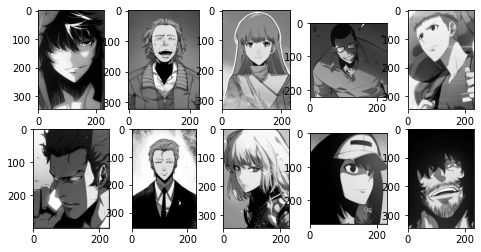

Similar title:  ['Mirai Nikki']


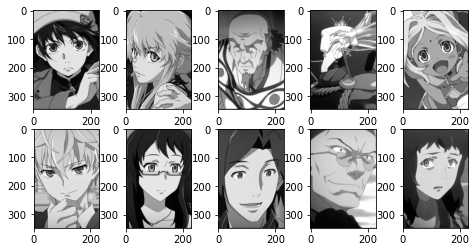

[53390, 105398, 30584]


In [4]:
res = ibr_search.recommend_titles_from_similar_image_embedding(query_title_id=30002, top_n=3)
print(res)